In [21]:
import pandas as pd
import numpy as np
import os

image_dir = '/root/autodl-tmp/lung-segment'
train_df = pd.read_csv(os.path.join(image_dir, 'train.csv'))
train_df.head()

,Unnamed: 0,images,masks
0,0,images/0.png,masks/0-mask.png
1,1,images/1.png,masks/1-mask.png
2,2,images/2.png,masks/2-mask.png
3,3,images/3.png,masks/3-mask.png
4,4,images/5.png,masks/5-mask.png


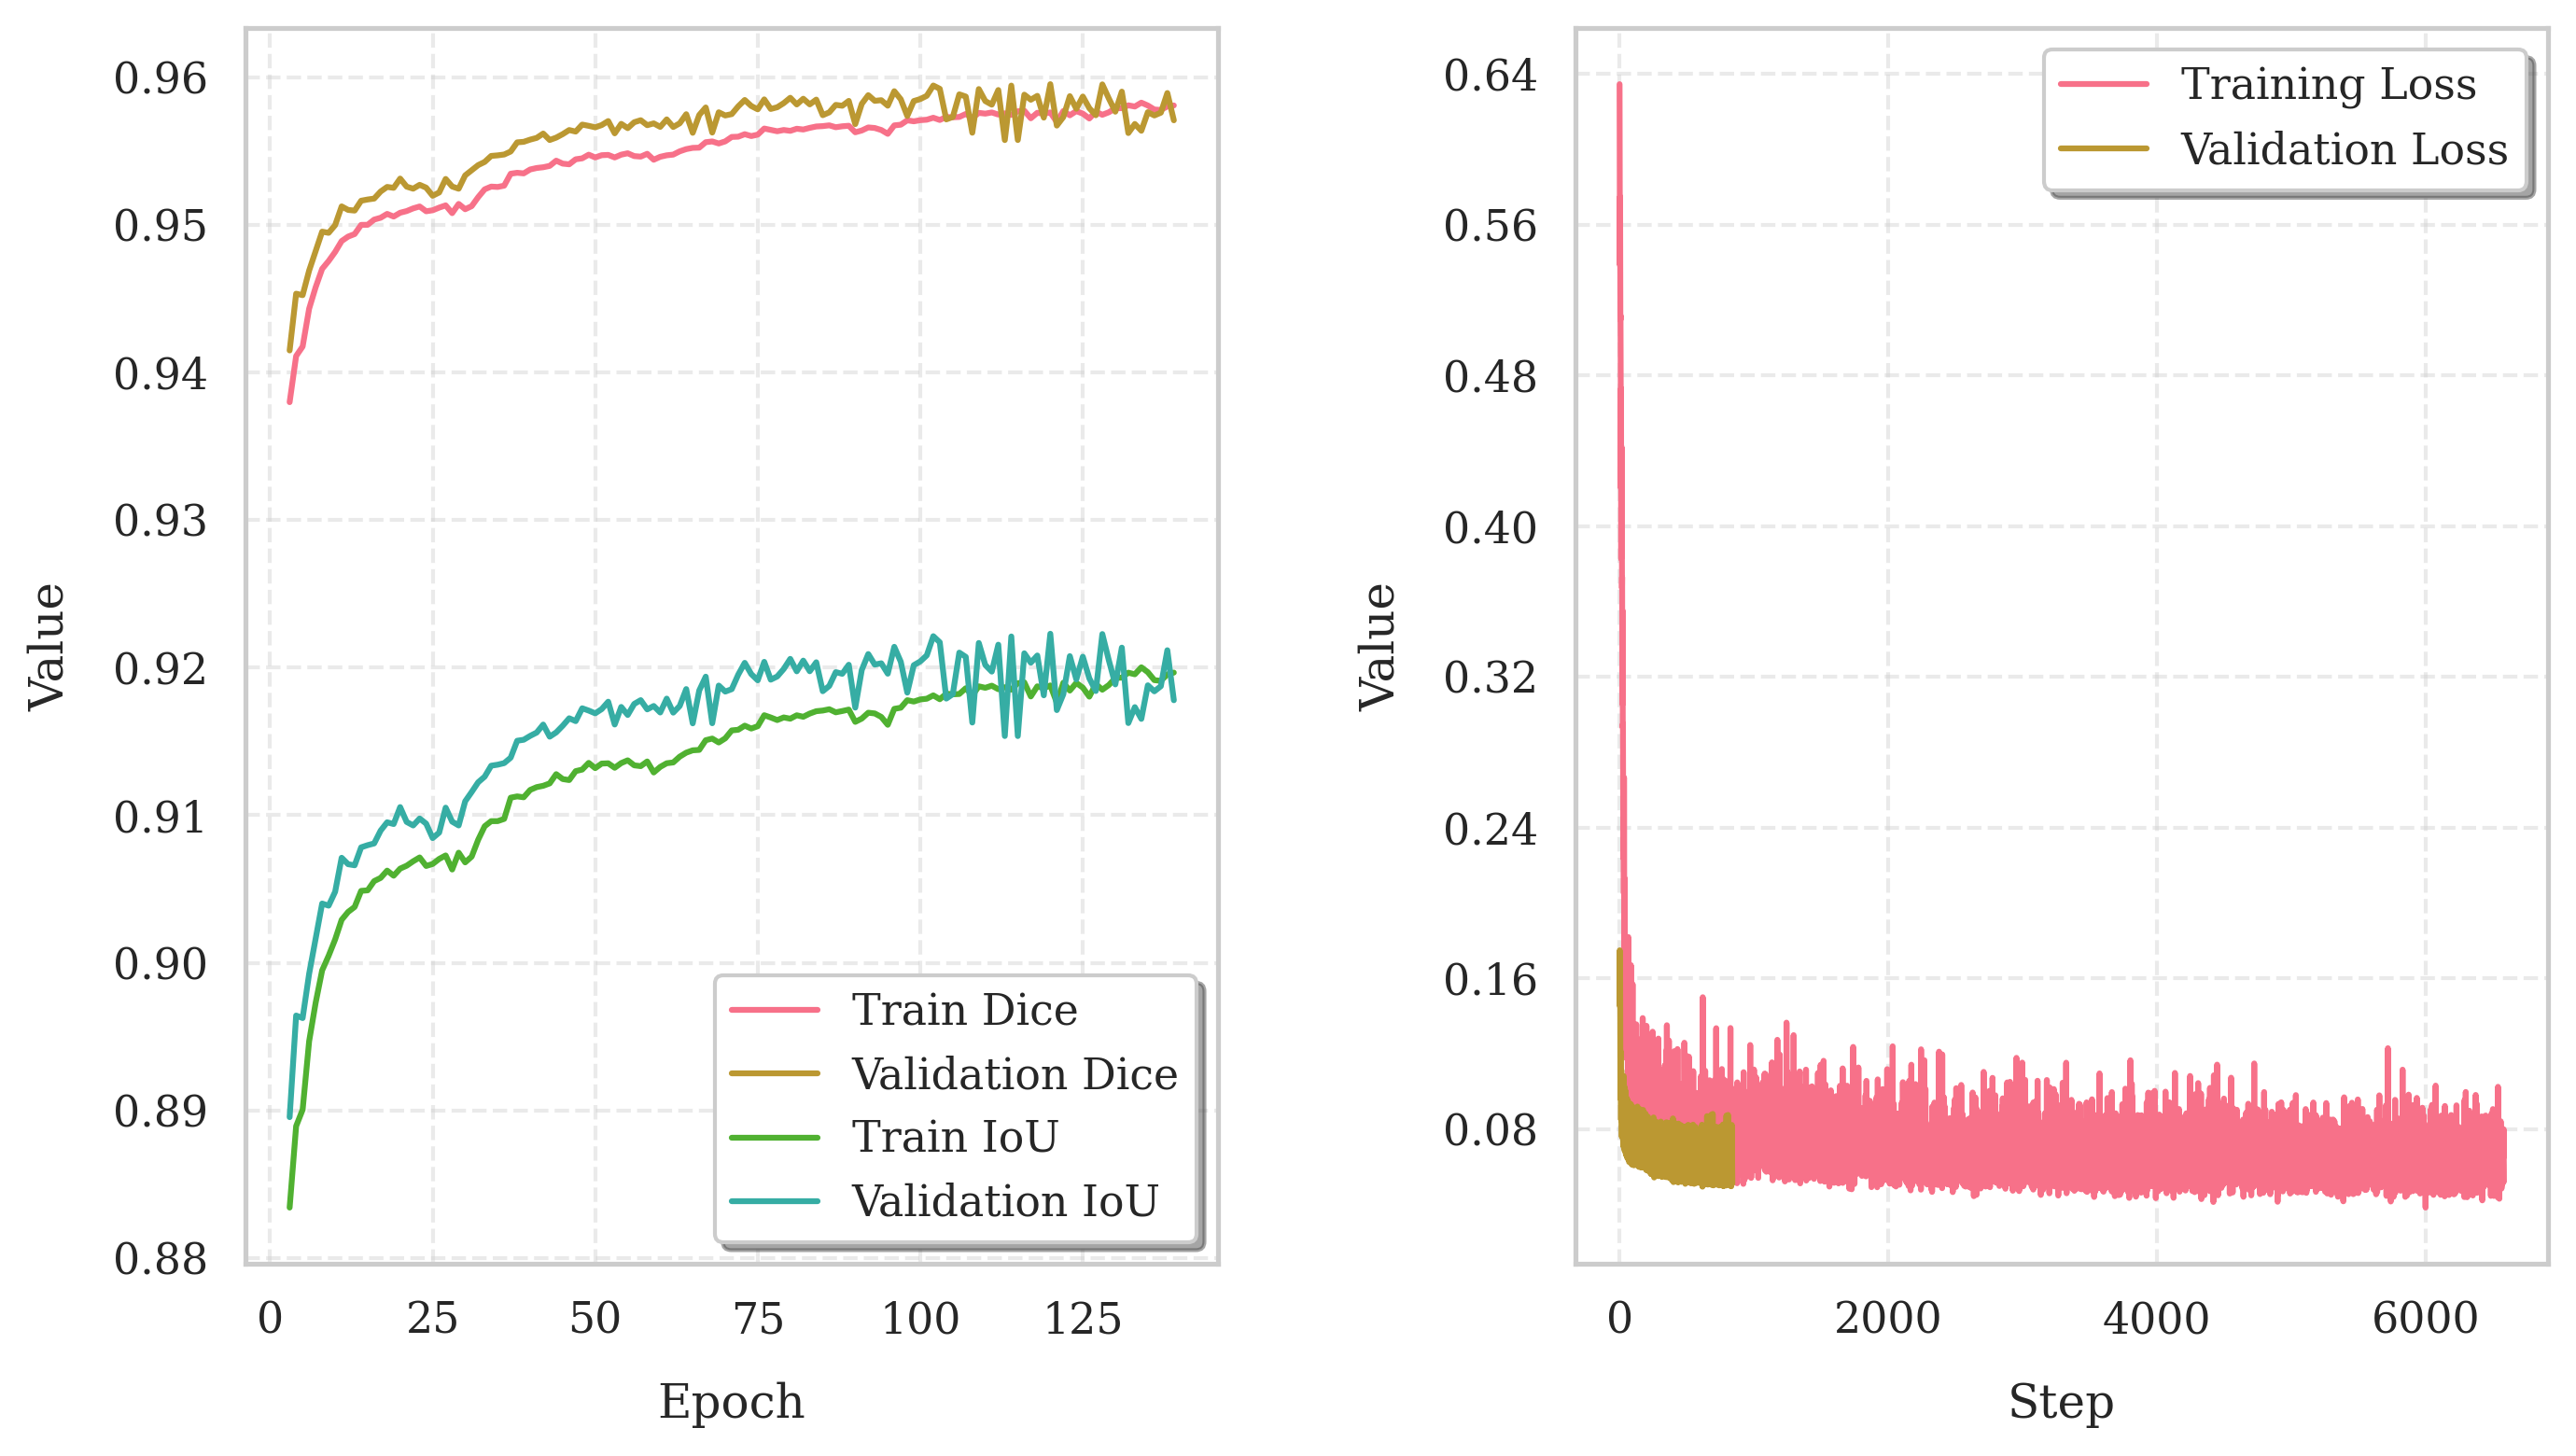

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

# 设置全局样式（在代码最前面运行一次即可）
%matplotlib inline
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({
    'font.family': 'serif',  # 学术论文常用字体
    'font.size': 12,
    'figure.figsize': (10, 6),        # 图像尺寸
    'figure.dpi': 300,                # 分辨率
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 1.5,           # 加粗线条
    'grid.alpha': 0.4                 # 半透明网格
})

# 生成示例数据（替换为你的真实数据）
data1 = pd.read_json('../CXR/training_data/fold_0/train_dice.json')
data2 = pd.read_json('../CXR/training_data/fold_0/validation_dice.json')
data3 = pd.read_json('../CXR/training_data/fold_0/train_iou.json')
data4 = pd.read_json('../CXR/training_data/fold_0/validation_iou.json')
train_loss = pd.read_json('../CXR/training_data/fold_0/train_loss.json')
val_loss = pd.read_json('../CXR/training_data/fold_0/validation_loss.json')


# 创建DataFrame
df = pd.DataFrame({'Train Dice': data1[0], 'Validation Dice': data2[0], 'Train IoU': data3[0], 'Validation IoU':data4[0]})

# 创建画布和坐标轴
fig, (ax1, ax2) = plt.subplots(1,2)

# 绘制双线图
sns.lineplot(data=df.iloc[3:], 
             dashes=False,  # 禁用自动虚线
             # drawstyle='steps-post',
             markersize=8,  # 标记尺寸
             ax=ax1)

df = pd.DataFrame({'Training Loss':train_loss[0], 'Validation Loss':val_loss[0]})
sns.lineplot(data=df, 
             dashes=False,  # 禁用自动虚线
             # drawstyle='steps-post',
             markersize=8,  # 标记尺寸
             ax=ax2)

# 优化元素
ax1.set_xlabel('Epoch', labelpad=10)
ax1.set_ylabel('Value', labelpad=10)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))        # Y轴整数刻度
ax1.grid(True, which='both', ls='--', alpha=0.4)              # 网格线

ax2.set_xlabel('Step', labelpad=10)
ax2.set_ylabel('Value', labelpad=10)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))        # Y轴整数刻度
ax2.grid(True, which='both', ls='--', alpha=0.4)              # 网格线

# 优化图例
ax1.legend(frameon=True, 
          shadow=True, 
          fancybox=True,
          loc='lower right') 
ax2.legend(frameon=True, 
          shadow=True, 
          fancybox=True,
          loc='upper right')

# 调整边距
plt.tight_layout(pad=3)

# 保存图片（矢量图适合印刷）
# plt.savefig('timeseries.svg', format='svg', bbox_inches='tight')
# plt.savefig('timeseries.png', dpi=300, bbox_inches='tight')

plt.show()

RGB


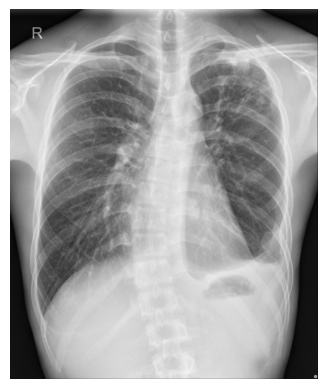

(55, 55, 55)

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def imshow(image):
    plt.imshow(image)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()
# 读取图片
image_path = "/root/autodl-tmp/lung-segment/images/0.png"
image = Image.open(image_path).convert("L").convert("RGB")
print(image.mode)
imshow(image)

# 创建可绘制对象
draw = ImageDraw.Draw(image)

In [23]:
np_image = np.array(image)
np_image.shape

(2945, 2450)

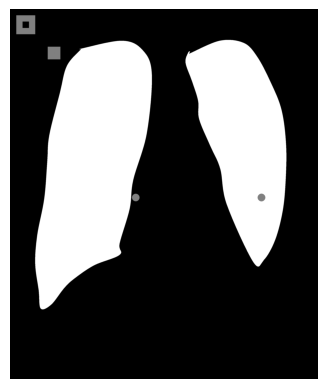

In [35]:
# 定义点的坐标（示例）
points = [
    (1000, 1500),  # 点1 (x, y)
    (2000, 1500),  # 点2
]

# 绘制点（红色圆点，半径3像素）
for (x, y) in points:
    draw.ellipse([(x-30, y-30), (x+30, y+30)], fill='gray', outline='red')

# 定义方框坐标（左上角x1,y1，右下角x2,y2）
boxes = [
    (50, 50, 200, 200),  # 方框1
    (300, 300, 400, 400),  # 方框2
]

# 绘制绿色方框（线宽2像素）
for box in boxes:
    draw.rectangle(box, outline='gray', width=50)

gray_imshow(image)

In [ ]:
# 使用示例
points, boxes = process_grayscale_image("/root/autodl-tmp/lung-segment/masks/0-mask.png")

# 打印结果
print("Points (原始图像坐标):")
for pt in points:
    print(f"  {pt}")

print("\nBoxes (原始图像坐标):")
for box in boxes:
    print(f"  {box}")
    
visualize("/root/autodl-tmp/lung-segment/images/0.png", points, boxes)

In [12]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


class SAMDataset(Dataset):
    def __init__(self, csv_path, img_size=1024):
        self.df = pd.read_csv(csv_path)
        self.img_size = img_size

        # 一致性增强参数容器
        self.shared_params = {}

        # 第一阶段：一致性增强（所有图像共享相同参数）
        self.consistent_aug = T.Compose([
            self.ColorJitterWithConsistency(
                brightness=0.1, contrast=0.03, saturation=0.03
            ),
            self.RandomGrayscaleWithConsistency(p=0.05)
        ])

        # 第二阶段：非一致性增强
        self.non_consistent_aug = T.Compose([
            self.ColorJitterWithConsistency(
                brightness=0.1, contrast=0.05, saturation=0.05,
                consistent_transform=False
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 读取原始数据
        base_path = '/root/autodl-tmp/lung-segment'
        img_path = self.df.iloc[idx]['images']
        mask_path = self.df.iloc[idx]['masks']

        image = Image.open(os.path.join(base_path, img_path)).convert('RGB')
        mask = Image.open(os.path.join(base_path, mask_path)).convert('L')

        # 重置共享参数
        self.shared_params = {}

        # 应用一致性增强（仅图像）
        image = self.consistent_aug(image)

        # 应用非一致性增强（仅图像）
        image = self.non_consistent_aug(image)

        # Resize
        image = image.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
        
        # 处理mask生成SAM提示
        points, boxes = self.find_entities(mask)
        labels = torch.ones(len(points), dtype=torch.int64)

        mask = torch.tensor(np.array(mask).astype(np.float32))

        return np.array(image), points, labels, boxes, mask

    def find_entities(self, mask):
        # 转为Numpy数组
        img_array = np.array(mask)

        # 连通域分析（假设白色为前景）
        labeled = label(img_array == 255)
        regions = regionprops(labeled)

        # 按面积排序，取前两大连通域
        sorted_regions = sorted(regions, key=lambda r: -r.area)[:2]
        if len(sorted_regions) < 2:
            raise ValueError("图像中未找到足够的目标实体（需要至少2个连通域）")

        # 初始化数据结构
        sam_points = []  # SAM格式：[x, y, label]
        sam_boxes = []  # SAM格式：[x_min, y_min, x_max, y_max]

        for region in sorted_regions:
            # 获取包围框坐标 (注意regionprops返回的bbox顺序)
            y_min, x_min, y_max, x_max = region.bbox
            sam_boxes.append([x_min, y_min, x_max, y_max])

            # 随机选择内部点（使用全局坐标）
            coords = region.coords  # 所有属于该区域的像素坐标 [y, x]
            rand_idx = np.random.choice(len(coords))
            y_pt, x_pt = coords[rand_idx]
            sam_points.append([x_pt, y_pt])  # label=1表示前景点
        
        norm_points = np.array([[x / self.img_size, y / self.img_size] for x, y in sam_points])
        boxes_norm = np.array([[x1/self.img_size, y1/self.img_size, x2/self.img_size, y2/self.img_size] for x1, y1, x2, y2 in sam_boxes])

        return torch.tensor(norm_points, dtype=torch.float32), torch.tensor(boxes_norm, dtype=torch.float32)

    class ColorJitterWithConsistency(T.ColorJitter):
        def __init__(self, consistent_transform=True, **kwargs):
            super().__init__(**kwargs)
            self.consistent_transform = consistent_transform
            self._params = None

        def forward(self, img):
            if self.consistent_transform:
                # 生成或复用参数
                if self._params is None:
                    self._params = self.get_params(
                        self.brightness, self.contrast,
                        self.saturation, self.hue
                    )
                fn_idx, brightness, contrast, saturation, hue = self._params
                for fn_id in fn_idx:
                    if fn_id == 0 and brightness is not None:
                        img = T.functional.adjust_brightness(img, brightness)
                    elif fn_id == 1 and contrast is not None:
                        img = T.functional.adjust_contrast(img, contrast)
                    elif fn_id == 2 and saturation is not None:
                        img = T.functional.adjust_saturation(img, saturation)
                    elif fn_id == 3 and hue is not None:
                        img = T.functional.adjust_hue(img, hue)
                return img
            else:
                return super().forward(img)

    class RandomGrayscaleWithConsistency(T.RandomGrayscale):
        def __init__(self, p=0.1, consistent_transform=True):
            super().__init__(p=p)
            self.consistent_transform = consistent_transform
            self._apply_grayscale = None

        def forward(self, img):
            if self.consistent_transform:
                if self._apply_grayscale is None:
                    self._apply_grayscale = torch.rand(1) < self.p
                if self._apply_grayscale:
                    return T.functional.rgb_to_grayscale(img, num_output_channels=3)
                return img
            else:
                return super().forward(img)

dataset = SAMDataset("/root/autodl-tmp/lung-segment/train.csv")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

l = []
for batch in dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape, batch[4].shape)
    break

torch.Size([4, 1024, 1024, 3]) torch.Size([4, 2, 2]) torch.Size([4, 2]) torch.Size([4, 2, 4]) torch.Size([4, 1024, 1024])


In [16]:
points = [[256, 256], [768, 768]]        # 绝对坐标
point_labels = [1, 0]                    # 标签（前景/背景）
boxes = [[100, 100, 400, 400], [600, 600, 900, 900]]  # 绝对坐标

# 归一化
H, W = 1024, 1024
points_norm = [[x/W, y/H] for x, y in points]
boxes_norm = [[x1/W, y1/H, x2/W, y2/H] for x1, y1, x2, y2 in boxes]
print(np.array(points_norm).shape, np.array(boxes_norm).shape)

(2, 2) (2, 4)


In [ ]:
points_tensor = torch.tensor(points_norm, dtype=torch.float32).unsqueeze(0).to("cuda")
points_tensor.shape

torch.Size([2, 2])

In [18]:
a = (1,2,3,4)
print(a[0])

1
